# TensorFlow - Simple Nerual Networks Sample Note

> 主要包含一些简单的NN结构构建例子

>> CNN: Convolutional Neural Network 卷积神经网络

>> RNN: Dynamic Recurrent Neural Network 动态RNN网络

>> LSTM: Bi-directional Recurrent Neural Network 双向RNN网络

>> AutoEncoder: a 2 layer Auto-Encoder Network

> 使用`MNIST`手写数据集

> 注意版本：`TensorFlow Ver2`

---

## 简单CNN构建
- 本例中的`CNN`结构简单，由数个`conv`，`pooling`与`full connect layer`直接构成
- 使用`tensorflow.keras`简化网络构建过程

### 参数定义，依赖与数据集引入
- 在此对`MNIST`数据直接执行`Normalisation`，将所有数据限制在：$Sample\in[0,1]$ 范围中
- 使用`tf.data`API构建批训练数据，并执行训练数据随机打散

In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow.keras import Model, layers, datasets 

LR = .01
EPOCH = 100
BATCH = 64
NUM_CLASS = 10

CONV1_DIM = 32
CONV1_FILTER = 5
CONV2_DIM = 64
CONV2_FILTER = 3
POOL_FILTER = 2
POOL_STRIDE = 2
FC_DIM = 1024
DROP_OUT = .4

IMG_DIM = 28 # MNIST 数据集图片维度：28x28 = 784
PIXELS = 255. 
SHUFFLE_SEED = 4274
DATASET_PATH = 'D:/CodeBase-User/MyPython-VSCode/dataset/Mnist/MNIST/mnist.npz'

(train_x, train_y), (test_x, test_y) = datasets.mnist.load_data(DATASET_PATH)
# Normalise the MNIST
train_x, test_x = np.array(train_x, np.float32) / PIXELS, np.array(test_x, np.float32) / PIXELS
# Shuffle the data & create batch data
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_data = train_data.repeat().shuffle(SHUFFLE_SEED).batch(BATCH).prefetch(1)

### 定义CNN网络结构
- 利用`tensorflow.keras`库进行快速搭建
- 整体流程与使用`pytorch`相似
- 主要定义**模型结构**与**前向传播**部分

In [8]:
class ConvNetwork(Model):

    def __init__(self):
        # 初始化网络各层参数
        super(ConvNetwork, self).__init__()
        # CONV：利用 5x5 的filter共32个对输入样本进行采样
        self.conv1 = layers.Conv2D(CONV1_DIM, CONV1_FILTER, activation=tf.nn.relu)
        # MaxPool：在 2x2 的区域中取最大区块并向后传递，步长(Stride)为2
        self.max_pool1 = layers.MaxPool2D(POOL_FILTER, strides=POOL_STRIDE)
        # CONV：利用 3x3 的filter共64个对输入样本进行采样
        self.conv2 = layers.Conv2D(CONV2_DIM, CONV2_FILTER, activation=tf.nn.relu)
        # MaxPool：在 2x2 的区域中取最大区块并向后传递，步长(Stride)为2
        self.max_pool2 = layers.MaxPool2D(POOL_FILTER, strides=POOL_STRIDE)
        # Flatten：将获得特征矩阵展开到一维，以送入FC层中继续传播
        self.flatten = layers.Flatten()
        # FC，Full-Connect layer：全链接层，将每个输入样本的特征映射到 1x1024 维
        self.fc = layers.Dense(FC_DIM)
        # Dropout：正则化策略，以设定的概率在 训练中 随机抹除部分神经元输出，非训练时应关闭
        self.dropout = layers.Dropout(rate=DROP_OUT)
        # 输出对齐任务需求，数据共有十个类别
        self.fcout = layers.Dense(NUM_CLASS)
        # 传入Softmax，将各类结果转化为概率评分
        self.softmax = layers.Softmax()
    
    # tensorflow.keras中将forward传播函数称为call，当然，函数本身叫啥都行
    def call(self, input_x, now_training=False):
        input_x = tf.reshape(input_x, [-1, IMG_DIM, IMG_DIM, 1])
        input_x = self.conv1(input_x)
        input_x = self.max_pool1(input_x)
        input_x = self.conv2(input_x)
        input_x = self.max_pool2(input_x)
        input_x = self.flatten(input_x)
        input_x = self.fc(input_x)
        # 注意，只有在训练时，Dropout才应当被启用
        input_x = self.dropout(input_x, training=now_training)
        input_x = self.fcout(input_x)
        # 相似的，Softmax方法也只有在非训练时启用
        if not now_training:
            input_x = self.softmax(input_x)
        output = input_x
        return output

### Loss与Optimizer部分定义
- 此处使用`Cross-Entropy Loss`：
    - 需求我们使用Softm，Sigmoid等激活函数，使输出结果为概率
- 定义`Accuracy`计算方法
- 定义Optimizer，此处使用`Adam`

> Hint：`tf.reduce_mean()`常接受1或2个参数，参数1为待分析Tensor，参数2为执行维度
>> 执行维度为0：按第一维为分割，针对每项求取平均值；执行维度为1：按第二维为分割，求取平均值 

In [9]:
optimizer = tf.optimizers.Adam(LR)

def cross_entropy_loss(input_x, label_y):
    # 将label_y转化为Cross-Entropy接受的int64格式
    label_y = tf.cast(label_y, dtype=tf.int64)
    # 计算loss，并返回reduce_mean
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_y, logits=input_x)
    return tf.reduce_mean(loss)

def accuracy(pred_y, label_y):
    # 概率最大的对应类别为最终输出类别，利用argmax选出同真实label进行比对
    num_of_corrects = tf.equal(tf.argmax(pred_y, 1), tf.cast(label_y, dtype=tf.int64))
    return tf.reduce_mean(tf.cast(num_of_corrects, dtype=tf.float32), axis=-1)

### 反向传播，参数优化部分定义
- 执行`backpropgation`，利用所得`loss`计算`gradient`
- 执行`batch training`策略
- 利用测试集衡量模型学习程度

In [10]:
# 获取模型
conv_network = ConvNetwork()
# 从shuffle后的数据集中迭代的不断按batch size取出数据
for epoch, (batch_x, batch_y) in enumerate(train_data.take(EPOCH), 1):
    with tf.GradientTape() as grad:
        # 前向传播开始
        prediction = conv_network(batch_x, now_training=True)
        # 计算当前批次Loss
        loss = cross_entropy_loss(prediction, batch_y)
    # 获取网络中需要更新的参数
    trainable_vars = conv_network.trainable_variables
    gradients = grad.gradient(loss, trainable_vars)
    # 调用优化器，对各参数进行更新学习
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    # 我们每10个批次学习后检测一下当前模型的学习成果
    if epoch % 10 is 0:
        cur_predition = conv_network(test_x)
        cur_loss = cross_entropy_loss(cur_predition, test_y)
        cur_accuracy = accuracy(cur_predition, test_y)
        print("Now at epoch: %i, current loss is: %f, current accuracy on test set is: %f." % (epoch, cur_loss, cur_accuracy))

Now at epoch: 10, current loss is: 1.761871, current accuracy on test set is: 0.806700.
Now at epoch: 20, current loss is: 1.579051, current accuracy on test set is: 0.899600.
Now at epoch: 30, current loss is: 1.607557, current accuracy on test set is: 0.901600.
Now at epoch: 40, current loss is: 1.561433, current accuracy on test set is: 0.927400.
Now at epoch: 50, current loss is: 1.568806, current accuracy on test set is: 0.916200.
Now at epoch: 60, current loss is: 1.554580, current accuracy on test set is: 0.938200.
Now at epoch: 70, current loss is: 1.553563, current accuracy on test set is: 0.932600.
Now at epoch: 80, current loss is: 1.531797, current accuracy on test set is: 0.942100.
Now at epoch: 90, current loss is: 1.514352, current accuracy on test set is: 0.955300.
Now at epoch: 100, current loss is: 1.541963, current accuracy on test set is: 0.939800.


### CNN结果可视化查看
- 使用`matplotlib`将样本及其预测结果输出，进行比对

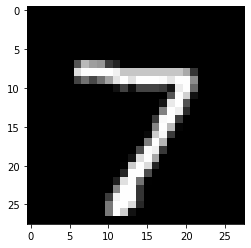

Image with label: 7 and predition: 7


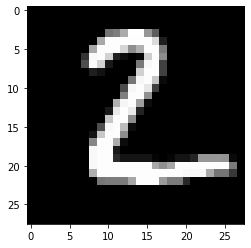

Image with label: 2 and predition: 2


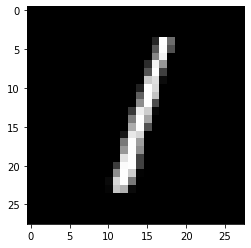

Image with label: 1 and predition: 1


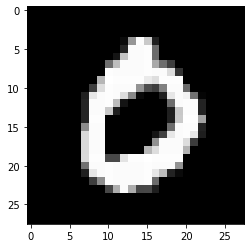

Image with label: 0 and predition: 0


In [13]:
import matplotlib.pyplot as plt 

img_num = 4
test_vis_img = test_x[:img_num]
test_label_img = test_y[:img_num]
test_pred_img = conv_network(test_vis_img)

for img in range(img_num):
    plt.imshow(np.reshape(test_vis_img[img], [28, 28]), cmap='gray')
    plt.show()
    print("Image with label: %i and predition: %i" % (test_label_img[img], np.argmax(test_pred_img.numpy()[img])))

---

## 简单RNN构建例子
- 具有考察`上下文依赖性`的功能
- 输入样本为一维的`stream`连续数据

### 超参数设置与训练数据处理
- 注意会将`MNIST`测试用数据从图片`展平`为一维数据

In [7]:
NUM_CLASS = 10

LR = .005
EPOCH = 100
BATCH = 64

LSTM_DIM = 32

(train_x, train_y), (test_x, test_y) = datasets.mnist.load_data(DATASET_PATH)
# 展平数据，并将数据正则化到[0,1]范围内
train_x, test_x = np.array(train_x, np.float32).reshape([-1, IMG_DIM, IMG_DIM]) / PIXELS, np.array(test_x, np.float32).reshape([-1, IMG_DIM, IMG_DIM]) / PIXELS 
# 随机打乱数据，并定义batch
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_data = train_data.repeat().shuffle(SHUFFLE_SEED).batch(BATCH).prefetch(1)

### 定义RNN网络结构
- 利用一层单向`LSTM`网络层进行特征分析
- 利用`FC`与`Softmax`进行类别打分

In [3]:
class RnnNetwork(Model):

    def __init__(self):
        super(RnnNetwork, self).__init__()
        # LSTM层定义
        self.lstm_layer = layers.LSTM(units=LSTM_DIM)
        # FC层定义
        self.fcout = layers.Dense(NUM_CLASS)
        # Softmax层定义
        self.softmax = layers.Softmax()

    def call(self, input_x, now_training=False):
        input_x = self.lstm_layer(input_x)
        input_x = self.fcout(input_x)
        # 启用Softmax注意当前模型状态
        if not now_training:
            input_x = self.softmax(input_x)
        out = input_x
        return out

### 定义Loss与Optimizer
- `Cross-Entropy` Loss 
- `Adam` Optimizer 

In [9]:
def cross_entropy_loss(predition, label):
    label = tf.cast(label, dtype=tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=prediction)
    return tf.reduce_mean(loss)

def accuracy(predition, label):
    num_of_corrects = tf.equal(tf.argmax(predition, 1), tf.cast(label, dtype=tf.int64))
    return tf.reduce_mean(tf.cast(num_of_corrects, dtype=tf.float32), axis=-1)

optimizer = tf.optimizers.Adam(LR)
# 本部分相较于上一个CNN示例并无变化

### 迭代训练
- 每10个`epoch`我们将输出一次`测试集`上的准确率进行模型训练效果查看

In [11]:
rnn_network = RnnNetwork()

for epoch, (batch_x, batch_y) in enumerate(train_data.take(EPOCH), 1):
    with tf.GradientTape() as grad:
        # Forward传播
        prediction = rnn_network(batch_x, now_training=True)
        loss = cross_entropy_loss(prediction, batch_y)
    # 参数获取
    trainable_vars = rnn_network.trainable_variables
    # 梯度计算
    gradients = grad.gradient(loss, trainable_vars)
    # 参数更新
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    # 计算Accuracy
    if epoch % 10 is 0:
        cur_prediction = rnn_network(test_x)
        cur_accuracy = accuracy(cur_prediction, test_y)
        print("Now at epoch: %i, current accuracy on test set is: %f." % (epoch, cur_accuracy))

Now at epoch: 10, current accuracy on test set is: 0.302800.
Now at epoch: 20, current accuracy on test set is: 0.424800.
Now at epoch: 30, current accuracy on test set is: 0.508600.
Now at epoch: 40, current accuracy on test set is: 0.556300.
Now at epoch: 50, current accuracy on test set is: 0.666000.
Now at epoch: 60, current accuracy on test set is: 0.673300.
Now at epoch: 70, current accuracy on test set is: 0.665000.
Now at epoch: 80, current accuracy on test set is: 0.714200.
Now at epoch: 90, current accuracy on test set is: 0.729900.
Now at epoch: 100, current accuracy on test set is: 0.749200.


---

## 简单双向LSTM网络模型构建